In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Create a sine wave dataset
For this exercise we'll look at a simple sine wave. We'll take 800 data points and assign 40 points per full cycle, for a total of 20 complete cycles. We'll train our model on all but the last cycle, and use that to evaluate our test predictions.

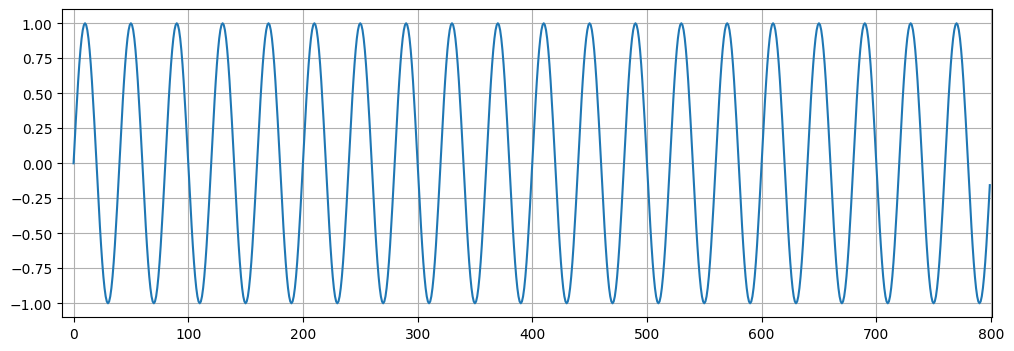

In [2]:
x = torch.linspace(0, 799, steps=800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(y.numpy())

## Create train and test sets
We want to take the first 760 samples in our series as a training sequence, and the last 40 for testing.
<div class="alert alert-info"><strong>NOTE:</strong> We tend to use the terms "series" and "sequence" interchangeably. Usually "series" refers to the entire population of data, or the full time series, and "sequence" refers to some portion of it.</div>

In [3]:
test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

In [4]:
train_set.shape

torch.Size([760])

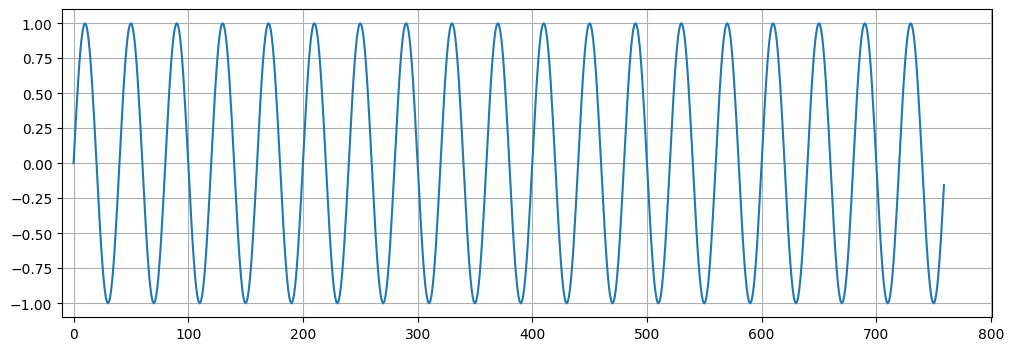

In [5]:
plt.figure(figsize=(12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(train_set.numpy())

## Prepare the training data
When working with LSTM models, we start by dividing the training sequence into a series of overlapping "windows". Each window consists of a connected string of samples. The label used for comparison is equal to the next value in the sequence. In this way our network learns what value should follow a given pattern of preceding values. Note: although the LSTM layer produces a prediction for each sample in the window, we only care about the last one.

For example, say we have a series of 15 records, and a window size of 5. We feed $[x_1,..,x_5]$ into the model, and compare the prediction to $x_6$. Then we backprop, update parameters, and feed $[x_2,..,x_6]$ into the model. We compare the new output to $x_7$ and so forth up to $[x_{10},..,x_{14}]$.

To simplify matters, we'll define a function called <tt>input_data</tt> that builds a list of <tt>(seq, label)</tt> tuples. Windows overlap, so the first tuple might contain $([x_1,..,x_5],[x_6])$, the second would have $([x_2,..,x_6],[x_7])$, etc. 

Here $k$ is the width of the window. Due to the overlap, we'll have a total number of <tt>(seq, label)</tt> tuples equal to $\textrm{len}(series)-k$

In [6]:
train_set[0:40]

tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
         7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
        -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01])

In [7]:
def input_data(seq, ws):#Ws is the window size here
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

<div class="alert alert-info"><strong>NOTE:</strong> "Windows" are different from "batches". In our example we'll feed one window into the model at a time, so our batch size would be 1. If we passed two windows into the model before we backprop and update weights, our batch size would be 2.</div>

In [8]:
window_size = 40

#Create the training dataset of sequence/label tuples
train_data = input_data(train_set, window_size)

len(train_data)

720

In [9]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [10]:
torch.set_printoptions(sci_mode=False)
train_data[0]

(tensor([     0.0000,      0.1564,      0.3090,      0.4540,      0.5878,
              0.7071,      0.8090,      0.8910,      0.9511,      0.9877,
              1.0000,      0.9877,      0.9511,      0.8910,      0.8090,
              0.7071,      0.5878,      0.4540,      0.3090,      0.1564,
             -0.0000,     -0.1564,     -0.3090,     -0.4540,     -0.5878,
             -0.7071,     -0.8090,     -0.8910,     -0.9511,     -0.9877,
             -1.0000,     -0.9877,     -0.9511,     -0.8910,     -0.8090,
             -0.7071,     -0.5878,     -0.4540,     -0.3090,     -0.1564]),
 tensor([    0.0000]))

## Define an LSTM model
Our model will have one LSTM layer with an input size of 1 and a hidden size of 50, followed by a fully-connected layer to reduce the output to the prediction size of 1.<br>
<div class="alert alert-info"><strong>NOTE:</strong> You will often see the terms <em>input_dim</em> and <em> hidden_dim</em> used in place of <em>input_size</em> and <em>hidden_size</em>. They mean the same thing. We'll stick to <em>input_size</em> and <em>hidden_size</em> to stay consistent with PyTorch's built-in keywords.</div>

During training we pass three tensors through the LSTM layer - the sequence, the hidden state $h_0$ and the cell state $c_0$.<br>

This means we need to initialize $h_0$ and $c_0$. This can be done with random values, but we'll use zeros instead.

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        #Add LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)

        #Add fully connected layer
        self.linear = nn.Linear(in_features=hidden_size, out_features=out_size)

        #Initialize h0 and c0
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]

## Instantiate the model, define loss & optimization functions
Since we're comparing single values, we'll use <a href='https://pytorch.org/docs/stable/nn.html#mseloss'><tt><strong>torch.nn.MSELoss</strong></tt></a><br>Also, we've found that <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.SGD'><tt><strong>torch.optim.SGD</strong></tt></a> converges faster for this application than <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><tt><strong>torch.optim.Adam</strong></tt></a>

In [12]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optmizer = torch.optim.SGD(model.parameters(), lr=0.01)

model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [13]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters()]
    for item in params:
        print(f"{item:>6}")
    print(f"_____\n{sum(params):>6}")

count_parameters(model)

   200
 10000
   200
   200
    50
     1
_____
 10651


## Predicting future values
To show how an LSTM model improves after each epoch, we'll run predictions and plot the results. Our goal is to predict the last sequence of 40 values, and compare them to the known data in our test set. However, we have to be careful <em>not</em> to use test data in the predictions - that is, each new prediction derives from previously predicted values.

The trick is to take the last known window, predict the next value, then <em>append</em> the predicted value to the sequence and run a new prediction on a window that includes the value we've just predicted. It's like adding track in front of the train as it's moving.<br> 

In this way, a well-trained model <em>should</em> follow any regular trends/cycles in the data.

## Train and simultaneously evaluate the model
We'll train 10 epochs. For clarity, we'll "zoom in" on the test set, and only display from point 700 to the end.

In [34]:
window_size = 40
my_list = [i for i in range(1, 101)]  # Example list from 1 to 20

print(my_list)
last_window = my_list[-window_size:]  
print(last_window) 
print(my_list[window_size:]) 
print(last_window[-window_size:])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [32]:
for seq, y_train in train_data:
    print(f"Seq : {seq}")
    print(f"y_train : {y_train}")
    break

Seq : tensor([     0.0000,      0.1564,      0.3090,      0.4540,      0.5878,
             0.7071,      0.8090,      0.8910,      0.9511,      0.9877,
             1.0000,      0.9877,      0.9511,      0.8910,      0.8090,
             0.7071,      0.5878,      0.4540,      0.3090,      0.1564,
            -0.0000,     -0.1564,     -0.3090,     -0.4540,     -0.5878,
            -0.7071,     -0.8090,     -0.8910,     -0.9511,     -0.9877,
            -1.0000,     -0.9877,     -0.9511,     -0.8910,     -0.8090,
            -0.7071,     -0.5878,     -0.4540,     -0.3090,     -0.1564])
y_train : tensor([    0.0000])


Epochs :  1 Loss : 0.09212878
Loss on test predictions: 0.6071590185165405


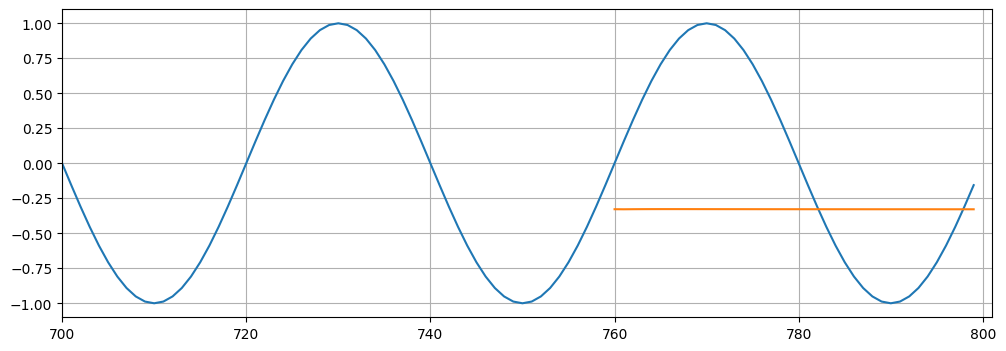

Epochs :  2 Loss : 0.06506767
Loss on test predictions: 0.5650987029075623


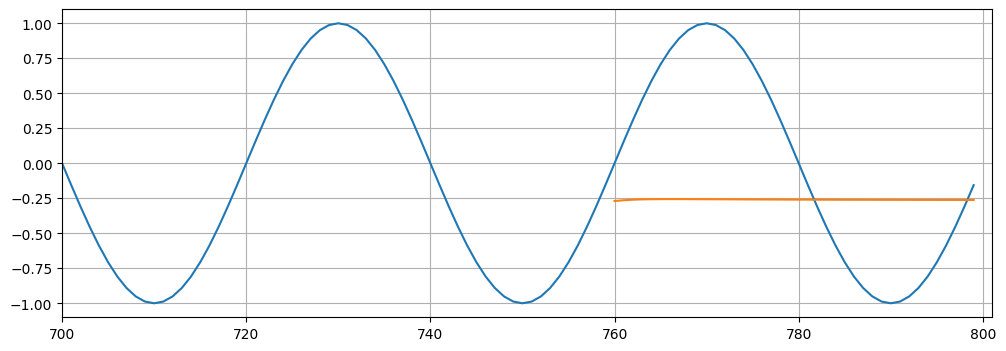

Epochs :  3 Loss : 0.04198049
Loss on test predictions: 0.5199716687202454


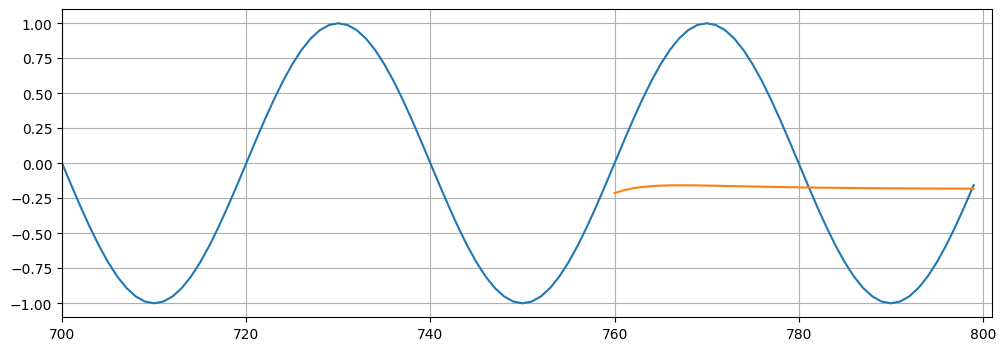

Epochs :  4 Loss : 0.01784276
Loss on test predictions: 0.42209967970848083


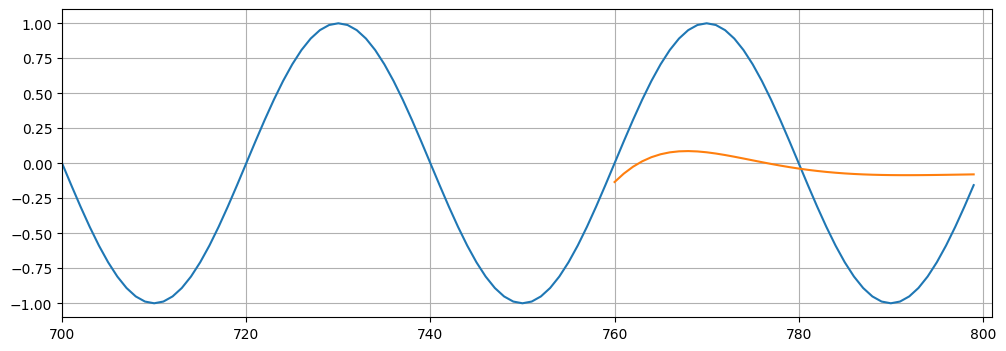

Epochs :  5 Loss : 0.00288710
Loss on test predictions: 0.16624116897583008


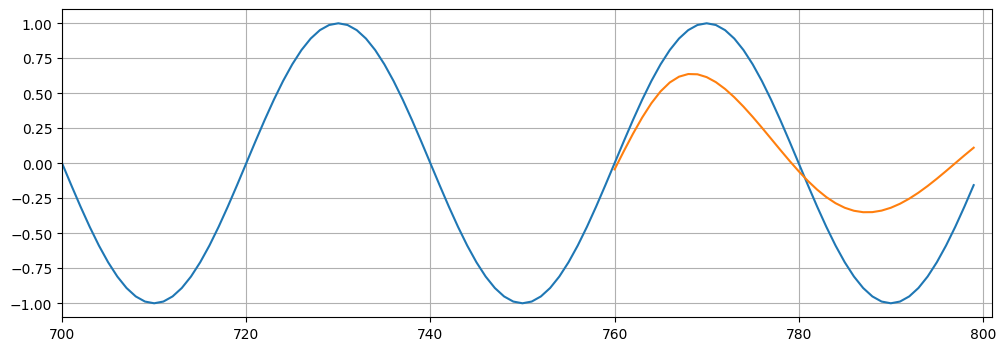

Epochs :  6 Loss : 0.00032007
Loss on test predictions: 0.030554482713341713


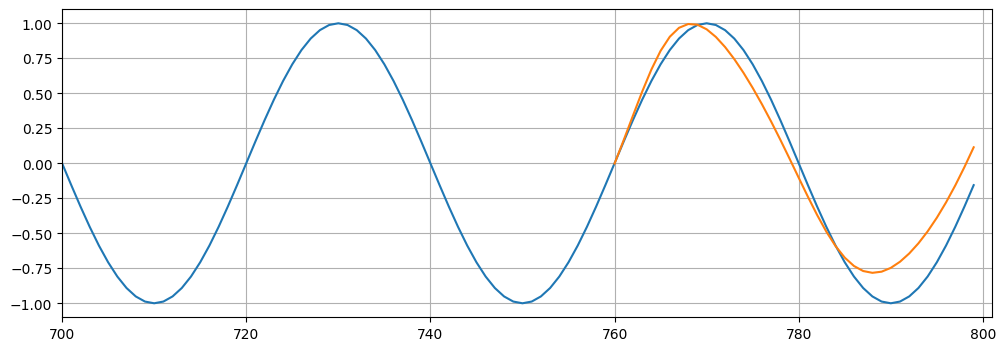

Epochs :  7 Loss : 0.00012969
Loss on test predictions: 0.014990163967013359


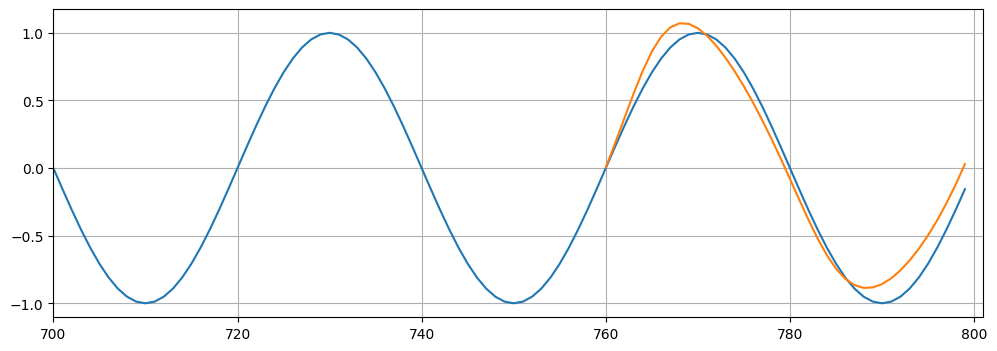

Epochs :  8 Loss : 0.00012007
Loss on test predictions: 0.011856677941977978


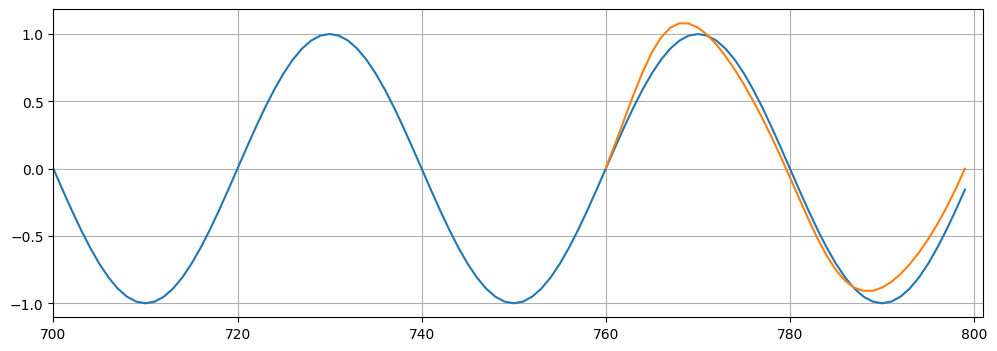

Epochs :  9 Loss : 0.00012656
Loss on test predictions: 0.010163769125938416


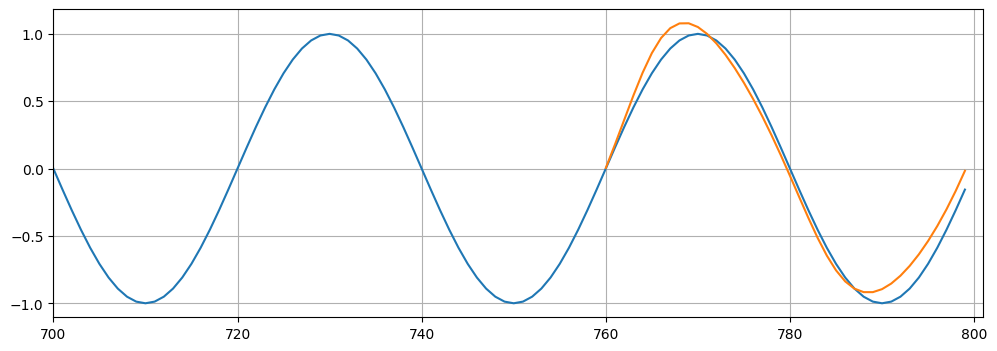

Epochs : 10 Loss : 0.00013195
Loss on test predictions: 0.00889760721474886


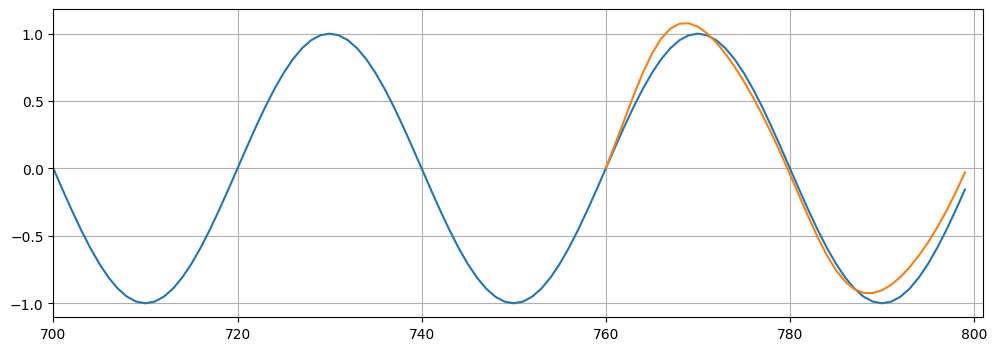

In [15]:
epochs = 10
future = 40

for i in range(epochs):

    #Tuple-unpack the train dataset
    for seq, y_train in train_data:

        #Reset the parameter and hidden state
        optmizer.zero_grad()
        model.hidden = (torch.zeros(1,1, model.hidden_size),
                        torch.zeros(1,1, model.hidden_size))
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optmizer.step()

    # Print training result
    print(f"Epochs : {i+1:2} Loss : {loss.item():10.8f}")

    # Make predictions
    # Start with a list of the last 40 training records
    preds = train_set[-window_size:].numpy().tolist()

    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1, model.hidden_size),
                            torch.zeros(1,1, model.hidden_size))
            preds.append(model(seq).item())
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])

    print(f'Loss on test predictions: {loss}')


    # Plot from point 700 to the end 
    plt.figure(figsize=(12,4))
    plt.xlim(700, 801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760, 800), preds[window_size:])
    plt.show()

In [20]:
seq.shape

torch.Size([40])

In [23]:
len(preds)

80

In [27]:
y.shape

torch.Size([800])

# Forecasting into an unknown future
We'll continue to train our model, this time using the entire dataset. Then we'll predict what the <em>next</em> 40 points should be.

## Train the model
Expect this to take a few minutes.

In [17]:
train_set.shape

torch.Size([760])

In [30]:
epochs = 15
window_size = 40
future = 40

# Create the full set of sequence/label tuples:
all_data = input_data(y, window_size)
len(all_data)

760

In [35]:
import time
start_time = time.time()

for i in range(epochs):
    # Tuple unpack the entire set of data
    for seq, y_train in all_data:
        # Reset paramaters and hidden states
        optmizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)

        loss.backward()
        optmizer.step()
    print(f"Epochs : {i+1:2} Loss : {loss.item():10.8f}")
print(f"\n Duration : {time.time() - start_time:.0f} Seconds")

Epochs :  1 Loss : 0.00013453
Epochs :  2 Loss : 0.00013443
Epochs :  3 Loss : 0.00013232
Epochs :  4 Loss : 0.00012879
Epochs :  5 Loss : 0.00012434
Epochs :  6 Loss : 0.00011931
Epochs :  7 Loss : 0.00011398
Epochs :  8 Loss : 0.00010854
Epochs :  9 Loss : 0.00010313
Epochs : 10 Loss : 0.00009784
Epochs : 11 Loss : 0.00009274
Epochs : 12 Loss : 0.00008788
Epochs : 13 Loss : 0.00008326
Epochs : 14 Loss : 0.00007890
Epochs : 15 Loss : 0.00007481

 Duration : 21 Seconds


#### Forcast into unknown future

In [38]:
y.shape

torch.Size([800])

In [47]:
# y[-window_size:]
preds

[0.00027750342269428074,
 0.15671049058437347,
 0.30928465723991394,
 0.4542362093925476,
 0.5880099534988403,
 0.7073045372962952,
 0.8091825246810913,
 0.8911352753639221,
 0.9511423707008362,
 0.9877321124076843,
 1.0,
 0.9876438975334167,
 0.9509681463241577,
 0.8908792734146118,
 0.8088510632514954,
 0.7069057822227478,
 0.5875537395477295,
 0.45373377203941345,
 0.308748334646225,
 0.15615351498126984,
 -0.0002864123380277306,
 -0.15671929717063904,
 -0.30929312109947205,
 -0.45424413681030273,
 -0.5880171656608582,
 -0.7073108553886414,
 -0.8091877698898315,
 -0.8911393284797668,
 -0.9511451721191406,
 -0.9877334833145142,
 -0.9999999403953552,
 -0.9876424670219421,
 -0.950965404510498,
 -0.8908752202987671,
 -0.8088458180427551,
 -0.7068995237350464,
 -0.5875465273857117,
 -0.45372581481933594,
 -0.30873987078666687,
 -0.15614472329616547,
 tensor([0.0026]),
 tensor([0.1715]),
 tensor([0.3433]),
 tensor([0.5114]),
 tensor([0.6676]),
 tensor([0.8033]),
 tensor([0.9114]),
 tensor

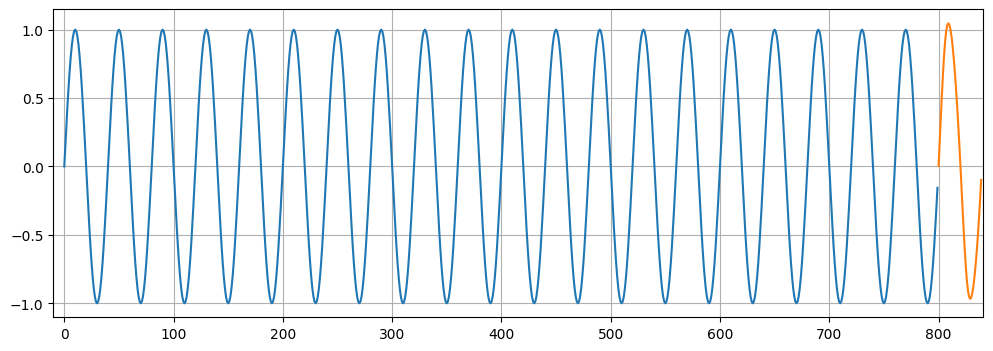

In [49]:
preds = y[-window_size:].numpy().tolist()

for i in range(future):
    seq = torch.FloatTensor(preds)
    with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

plt.figure(figsize=(12, 4))
plt.xlim(-10, 841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800, 800+future), preds[window_size:])
plt.show()